# Comparing the different proposed models

In [1]:
import pandas as pd
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
VARIABLE = 'MonthlyIncome'
COMPARE_METRIC = 'waic' # metric for comparing the models, options are 'waic' or 'loo'

---

Read the data

In [3]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Enriched/ProvincesProvinceIdRegion.csv")

In [4]:
Dat = pd.merge(Dat, ProvincesProvinceIdRegion, on='ProvinceId')

In [5]:
Dat['Region'] = Dat['Region'].replace(
    {
        'NorthernThailand': 'Northern Thailand'
        , 'SouthernThailand': 'Southern Thailand'
        , 'WesternThailand': 'Western Thailand'
        , 'EasternThailand': 'Eastern Thailand'
        , 'NortheastThailand': 'Northeast Thailand'
        , 'CentralThailand': 'Central Thailand'
    }
)

Calculate the statistics per region

In [6]:
DatRegion = Dat[[VARIABLE + 'Mean', 'Region']].groupby('Region').agg(['count', 'mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '':'Region'
        , 'count': 'NumberObservations'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'}
    )

DatRegion = DatRegion.sort_values(VARIABLE + 'Mean').reset_index(drop=True)

J = len(DatRegion)
DatRegion['RegionOrder'] = range(J)

In [7]:
Dat = Dat[[VARIABLE + 'Mean', 'Region']]
Dat = pd.merge(Dat, DatRegion[['Region', 'RegionOrder']])

---

Estimate $\nu$

In [8]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

In [9]:
HatNu = 2 * ES2**2 / VS2 + 4

----

Separate models for each region

In [10]:
with pm.Model() as ModelSeparate:
    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Theta  = pm.Flat('Theta', shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma[Dat['RegionOrder']], observed=Dat[VARIABLE + 'Mean'])

Pooled model

In [11]:
with pm.Model() as ModelPooled:
    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Theta  = pm.Flat('Theta')
    
    Income = pm.Normal('Income', mu=Theta, sigma=Sigma, observed=Dat[VARIABLE + 'Mean'])

Model with common $\sigma^2$

In [12]:
with pm.Model() as ModelCommonSigma:
    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma, observed=Dat[VARIABLE + 'Mean'])

Model with non-common $\sigma^2$ and estimated $\nu$

In [13]:
with pm.Model() as ModelEstimatedNu:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=HatNu/2, beta=HatNu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma[Dat['RegionOrder']], observed=Dat[VARIABLE + 'Mean'])

Model with non-common $\sigma^2$ and $\nu\sim\textsf{Exponential}(1/\hat\nu)$

In [14]:
with pm.Model() as ModelExponentialNu:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=HatNu/2, beta=HatNu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma[Dat['RegionOrder']], observed=Dat[VARIABLE + 'Mean'])

Model with non-common $\sigma^2$ and $p(\nu)\propto 1/\nu^3$

In [15]:
with pm.Model() as ModelH3:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu     = pm.HalfFlat('Nu')
    pm.Potential('p(Nu)', -3*pm.math.log(Nu))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma[Dat['RegionOrder']], observed=Dat[VARIABLE + 'Mean'])

Model with non-common $\sigma^2$ and $p(\nu)\propto 1/\nu^2$

In [16]:
with pm.Model() as ModelH2:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu     = pm.HalfFlat('Nu')
    pm.Potential('p(Nu)', -2*pm.math.log(Nu))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma[Dat['RegionOrder']], observed=Dat[VARIABLE + 'Mean'])

Model with non-common $\sigma^2$ and $p(\nu)\propto 1/\nu^{3/2}$

In [17]:
if False:
    with pm.Model() as ModelH32:
        Rho    = pm.HalfFlat('Rho')
        pm.Potential('p(Rho)', -pm.math.log(Rho))

        Nu     = pm.HalfFlat('Nu')
        pm.Potential('p(Nu)', -3/2*pm.math.log(Nu))

        Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
        Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

        Tau    = pm.HalfFlat('Tau')
        Mu     = pm.Flat('Mu')
        Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

        Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma[Dat['RegionOrder']], observed=Dat[VARIABLE + 'Mean'])

Model with non-common $\sigma^2$ and $p(\nu)\propto 1/\nu$

In [18]:
with pm.Model() as ModelH1:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu     = pm.HalfFlat('Nu')
    pm.Potential('p(Nu)', -pm.math.log(Nu))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma[Dat['RegionOrder']], observed=Dat[VARIABLE + 'Mean'])

---

Get a sample from the posterior

In [19]:
TraceSeparate    = pm.sample(model = ModelSeparate)
TracePooled      = pm.sample(model = ModelPooled)
TraceCommonSigma = pm.sample(model = ModelCommonSigma)
TraceEstimatedNu = pm.sample(model = ModelEstimatedNu)
TraceExponentialNu = pm.sample(model = ModelExponentialNu)
TraceH3          = pm.sample(model = ModelH3)
TraceH2          = pm.sample(model = ModelH2)
#TraceH32         = pm.sample(model = ModelH32)
TraceH1          = pm.sample(model = ModelH1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.


---

Compute the loglikelihood and compare the models

In [20]:
pm.compute_log_likelihood(TraceSeparate, model = ModelSeparate)
pm.compute_log_likelihood(TracePooled, model = ModelPooled)
pm.compute_log_likelihood(TraceCommonSigma, model = ModelCommonSigma)
pm.compute_log_likelihood(TraceEstimatedNu, model = ModelEstimatedNu)
pm.compute_log_likelihood(TraceExponentialNu, model = ModelExponentialNu)
pm.compute_log_likelihood(TraceH3, model = ModelH3)
pm.compute_log_likelihood(TraceH2, model = ModelH2)
#pm.compute_log_likelihood(TraceH32, model = ModelH32)
pm.compute_log_likelihood(TraceH1, model = ModelH1)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

---

Compare the models

In [23]:
CompareTable= az.compare(
    {
        "No Pooling": TraceSeparate
        , "Complete Pooling": TracePooled
        , "Common Sigma": TraceCommonSigma
        , "Estimated Nu": TraceEstimatedNu
        , "Exponential Nu": TraceExponentialNu
        , "H3": TraceH3
        , "H2": TraceH2
        #, "H1.5": TraceH32
        , "H1": TraceH1
    }
    , ic = COMPARE_METRIC
    , scale = 'deviance'
)

In [24]:
CompareTable.loc[
    ['No Pooling', 'Complete Pooling', 'Common Sigma', 'Estimated Nu', 'Exponential Nu', 'H3', 'H2', 'H1']
    , 'elpd_' + COMPARE_METRIC
].round(2)

No Pooling          1382.42
Complete Pooling    1410.17
Common Sigma        1386.77
Estimated Nu        1379.19
Exponential Nu      1379.12
H3                  1380.34
H2                  1380.20
H1                  1380.82
Name: elpd_waic, dtype: float64

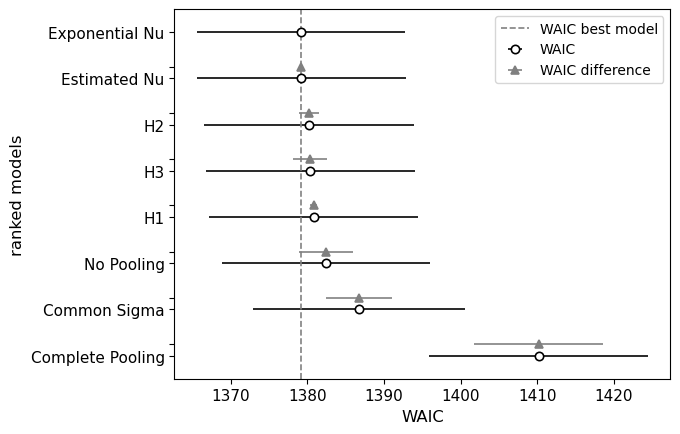

In [25]:
_, axes = plt.subplots(1,1)

az.plot_compare(
    CompareTable
    , textsize = 11
    , figsize = (10,5)
    , ax = axes
    , title =  False
    )

axes.set_xlabel(str.upper(COMPARE_METRIC))
axes.legend([str.upper(COMPARE_METRIC) + " best model", str.upper(COMPARE_METRIC), str.upper(COMPARE_METRIC) + ' difference'])